<a href="https://colab.research.google.com/github/teruyo14/DINO/blob/main/DINO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DINO

In [ ]:
! [ -e /content ] && pip install -Uqq self-supervised

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.7/705.7 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 57.2 MB/s eta 0:00:00


In [ ]:
from fastai.vision.all import *
from self_supervised.augmentations import *
from self_supervised.layers import *
from self_supervised.models.vision_transformer import *

/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


In [ ]:
class DINOHead(nn.Module):
    def __init__(self, in_dim, out_dim, use_bn=False, norm_last_layer=True, nlayers=3, hidden_dim=2048, bottleneck_dim=256):
        super().__init__()
        nlayers = max(nlayers, 1)
        if nlayers == 1:
            self.mlp = nn.Linear(in_dim, bottleneck_dim)
        else:
            layers = [nn.Linear(in_dim, hidden_dim)]
            if use_bn:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.GELU())
            for _ in range(nlayers - 2):
                layers.append(nn.Linear(hidden_dim, hidden_dim))
                if use_bn:
                    layers.append(nn.BatchNorm1d(hidden_dim))
                layers.append(nn.GELU())
            layers.append(nn.Linear(hidden_dim, bottleneck_dim))
            self.mlp = nn.Sequential(*layers)

        self.apply(self._init_weights)

        self.last_layer = nn.utils.weight_norm(nn.Linear(bottleneck_dim, out_dim, bias=False))
        self.last_layer.weight_g.data.fill_(1)
        if norm_last_layer:
            self.last_layer.weight_g.requires_grad = False

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.mlp(x)
        x = nn.functional.normalize(x, dim=-1, p=2)
        x = self.last_layer(x)
        return x

In [ ]:
@delegates(get_multi_aug_pipelines, but=['n', 'size', 'resize_scale'])
def get_dino_aug_pipelines(num_crops=(2,4), crop_sizes=(224,96), min_scales=(0.4,0.05), max_scales=(1.,0.4), **kwargs):
    aug_pipelines = []
    for nc, size, mins, maxs in zip(num_crops, crop_sizes, min_scales, max_scales):
        aug_pipelines += get_multi_aug_pipelines(n=nc, size=size, resize_scale=(mins,maxs), **kwargs)
    return aug_pipelines

In [ ]:
aug_pipelines = get_dino_aug_pipelines()

In [ ]:
class DINOModel(Module):
    def __init__(self, student, teacher):
        "A module for loading and saving all training params together"
        self.student,self.teacher = student,teacher
        self.teacher.load_state_dict(student.state_dict())
        for p in self.teacher.parameters(): p.requires_grad = False
        self.register_buffer('C',  torch.zeros(1,num_features_model(teacher)))
    def forward(self,x): return self.student(x)

In [ ]:
bs = 4
x_large = [torch.randn(4,3,224,224)]*2
x_small = [torch.randn(4,3,96,96)]*4

In [ ]:
deits16 = deit_small(patch_size=16, drop_path_rate=0.1)
deits16 = MultiCropWrapper(deits16)
dino_head = DINOHead(deits16.encoder.embed_dim, 2**16, norm_last_layer=True)
student_model = nn.Sequential(deits16,dino_head)

deits16 = deit_small(patch_size=16)
deits16 = MultiCropWrapper(deits16)
dino_head = DINOHead(deits16.encoder.embed_dim, 2**16, norm_last_layer=True)
teacher_model = nn.Sequential(deits16,dino_head)

dino_model = DINOModel(student_model, teacher_model)

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [ ]:
dino_model.student[1]

DINOHead(
  (mlp): Sequential(
    (0): Linear(in_features=384, out_features=2048, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=2048, out_features=2048, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=2048, out_features=256, bias=True)
  )
  (last_layer): Linear(in_features=256, out_features=65536, bias=False)
)

In [ ]:
class DINO(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines, large_crop_ids=[0,1],
                         cmom=0.9,
                         tmom_start=0.996, tmom_end=1., tmom_sched=SchedCos,
                         tpt_start=0.04, tpt_end=0.04, tpt_warmup_pct=0., tpt_sched=SchedLin,
                         tps=0.1,
                         freeze_last_layer=1,
                         print_augs=False):

        store_attr('large_crop_ids,cmom,freeze_last_layer,tps')
        self.augs = aug_pipelines
        self.tpt_scheduler  = combine_scheds([tpt_warmup_pct,1-tpt_warmup_pct],
                                             [tpt_sched(tpt_start,tpt_end),SchedNo(tpt_end,tpt_end)])
        self.tmom_scheduler = tmom_sched(tmom_start, tmom_end)
        if print_augs:
            for aug in self.augs: print(aug)


    def before_fit(self):
        "Create teacher model as a copy of student"
        self.learn.loss_func = self.lf
        self.tpt  = self.tpt_scheduler(0.)
        self.tmom = self.tmom_scheduler(0.)
        self.model.teacher.eval()

        for n,p in self.learn.model.student[1].last_layer.named_parameters():
            if n == 'weight_v' : p.requires_grad = False


    def before_batch(self):
        "Augment multi crop views"
        self.bs = self.x.size(0)
        self.learn.xb = ([aug(self.x) for aug in self.augs],)
        x_large = [self.learn.xb[0][i] for i in self.large_crop_ids]

        with torch.no_grad():
            targs = self.model.teacher(x_large)
            self.learn.yb = (targs,)
            self.cb       = targs.mean(0, keepdim=True)


    def _momentum_update_teacher(self):
        for param_s, param_t in zip(self.learn.model.student.parameters(), self.model.teacher.parameters()):
            param_t.data = param_t.data * self.tmom + param_s.data * (1. - self.tmom)


    def _momentum_update_center(self):
        self.model.C = self.model.C*self.cmom + self.cb*(1-self.cmom)


    def after_step(self):
        "Center and teacher updates"
        self._momentum_update_teacher(); self._momentum_update_center()


    def after_epoch(self):
        "Update tpt at the end of each epoch"
        self.tpt  = self.tpt_scheduler(self.pct_train)
        self.tmom = self.tmom_scheduler(self.pct_train)

        if self.epoch == self.freeze_last_layer:
            print("Setting last layer to trainable")
            for n,p in self.learn.model.student[1].last_layer.named_parameters():
                if n == 'weight_v' : p.requires_grad = True


    def lf(self, pred, *yb):
        "Multi crop cross entropy loss: -qlog(p)"
        yb = yb[0]
        pred = F.log_softmax(pred / self.tps, dim=-1)
        yb   = F.softmax((yb - self.model.C) / self.tpt, dim=-1)

        n_targs, n_preds = yb.size(0)//self.bs, pred.size(0)//self.bs
        yb, pred = yb.chunk(n_targs), pred.chunk(n_preds)

        loss, npairs = 0, n_targs*(n_preds-1)
        for ti in range(n_targs):
            for pi in range(n_preds):
                if ti != pi:
                    loss += (-yb[ti]*pred[pi]).sum(-1).mean() / npairs
        return loss



    @torch.no_grad()
    def show(self, n=1):
        xbs = self.learn.xb[0]
        idxs = np.random.choice(range(self.bs), n, False)
        images = [aug.decode(xb.to('cpu').clone()).clamp(0, 1)[i]
                  for i in idxs
                  for xb, aug in zip(xbs, self.augs)]
        return show_batch(images[0], None, images, max_n=len(images), nrows=n)

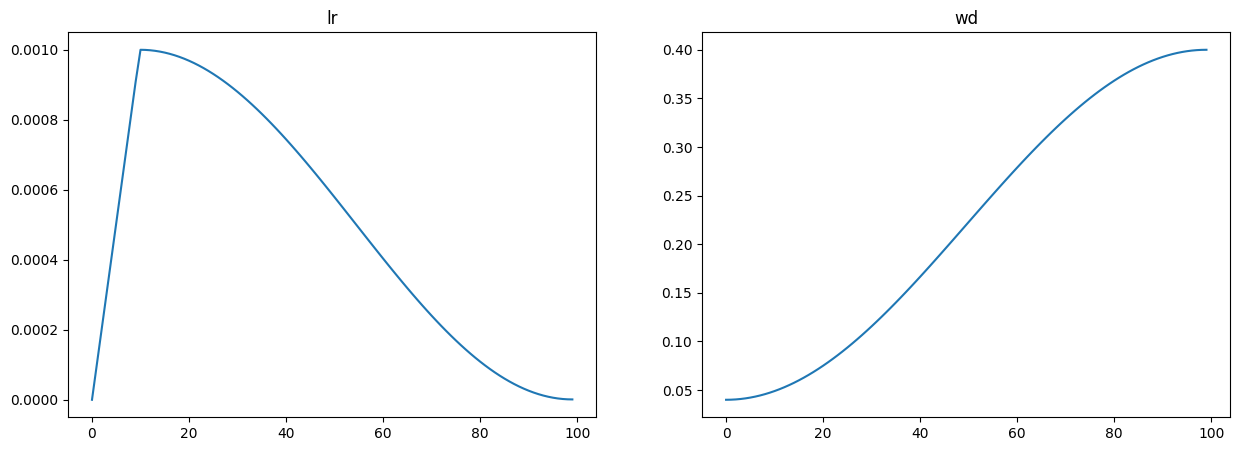

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
lr_sched = combine_scheds([0.1,0.9], [SchedLin(0.,1e-3), SchedCos(1e-3,1e-6)])
ax[0].plot([lr_sched(i) for i in np.linspace(0,1,100)]);ax[0].set_title('lr')
wd_sched = SchedCos(0.04,0.4)
ax[1].plot([wd_sched(i) for i in np.linspace(0,1,100)]);ax[1].set_title('wd');